Results on jobid 53341363.

After the conclusions based off of jobid 53232482 were implemented.

In [36]:
import numpy as np
from astroclip.utils import load_config, download_desi_dataset, format_axes
from astroclip.transforms import Permute, NormaliseSpectrum, Squeeze, DropOnRedshift, DropInvalidSpectra, ExtractKey
from astroclip.blocks import SpectrumEncoderSpender
from astroclip.models import ContrastiveBimodalPretraining
import torch
import torch.nn as nn
from torchvision.transforms import CenterCrop
from pl_bolts.models.self_supervised import Moco_v2
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from astroclip.training_utils import create_dataloaders, get_cross_modal_transforms

In [37]:
config, hparams = load_config('local', 'h08')

cache_dir = config['cache_dir']
output_dir = config['output_dir']

In [38]:
dataset, train_loader, val_loader = create_dataloaders(
    cache_dir, hparams['batch_size'], config['astroclip']['num_workers']
)

cross_modal_transforms = get_cross_modal_transforms()

val_redshifts = torch.Tensor([])
with torch.no_grad():
    for batch in tqdm(val_loader):
        batch = cross_modal_transforms(batch)
        val_redshifts = torch.cat([val_redshifts, batch['redshift']])

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 77/77 [00:48<00:00,  1.59it/s]


In [39]:
folder = 'astroclip_ckpt_53341353'
epoch = 5

spectrum_embeddings = torch.load(f'{output_dir}/{folder}/epoch{epoch}_spectrum_embeddings.pt').numpy()
image_embeddings = torch.load(f'{output_dir}/{folder}/epoch{epoch}_image_embeddings.pt').numpy()

redshifts = val_redshifts.numpy()
redshifts = redshifts[0:spectrum_embeddings.shape[0]]

In [40]:
def predict_redshifts(source_embedding, target_embedding, n_neighbours=16):
    """
    Predict redshift for the embeddings given in source_embeddings, using their closest neighbours in
    target_embeddings.
    """
    assert (
        source_embedding.shape[0] == target_embedding.shape[0]
    ), 'Embeddings must have the same dimension'
    assert (
        source_embedding.shape[1] == target_embedding.shape[1]
    ), 'Embeddings must have the same dimension'
    
    num_embeddings = source_embedding.shape[0]
    actual_redshifts = val_redshifts[0 : target_embedding.shape[0]]

    neighbours = NearestNeighbors(n_neighbors=n_neighbours, algorithm='auto').fit(
        target_embedding
    )
    
    distances, indices = neighbours.kneighbors(source_embedding)
    predicted_redshifts = np.array(
        [actual_redshifts[indices[i]].mean() for i in range(num_embeddings)]
    )
    
    return actual_redshifts, predicted_redshifts

def plot_r2_score(ax, redshifts, predicted_redshifts, title):
    r2 = r2_score(redshifts, predicted_redshifts)
    
    ax.scatter(redshifts, predicted_redshifts, s=1)
    ax.set_xlim(-0.05, 0.85)
    ax.set_ylim(-0.05, 0.85)
    ax.plot(np.linspace(0, 0.8, 100), np.linspace(0, 0.8, 100), color='orange', linestyle='--')
    
    ax.set_xlabel('True redshift')
    ax.set_ylabel('Predicted redshift')
    ax.text(0.05, 0.7, rf'$R^2$ score = {r2:.2f}', fontsize=12)
    ax.set_title(title, fontsize=10)

In [41]:
actual_redshifts, ss_predicted_redshifts = predict_redshifts(spectrum_embeddings, spectrum_embeddings)
actual_redshifts, ii_predicted_redshifts = predict_redshifts(image_embeddings, image_embeddings)
actual_redshifts, si_predicted_redshifts = predict_redshifts(spectrum_embeddings, image_embeddings)
actual_redshifts, is_predicted_redshifts = predict_redshifts(image_embeddings, spectrum_embeddings)

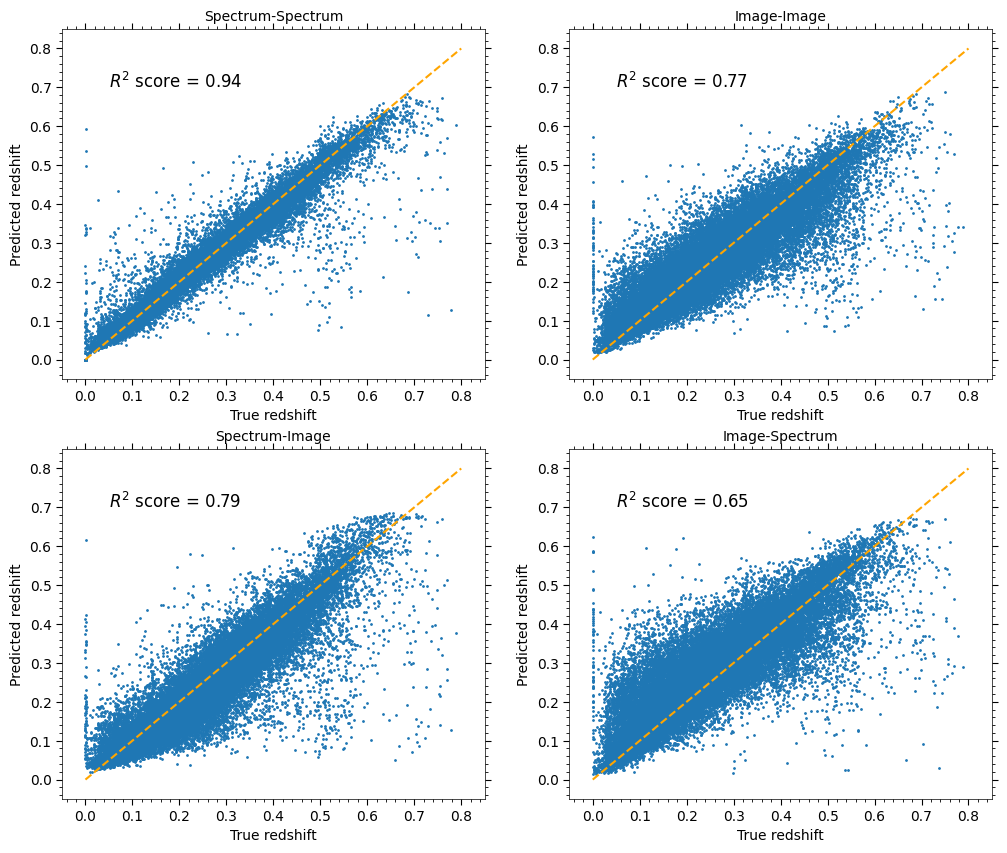

In [43]:
fig, ax = plt.subplots(figsize=(12, 10), nrows=2, ncols=2)
plot_r2_score(ax[0, 0], actual_redshifts.numpy(), ss_predicted_redshifts, title='Spectrum-Spectrum')
plot_r2_score(ax[0, 1], actual_redshifts.numpy(), ii_predicted_redshifts, title='Image-Image')
plot_r2_score(ax[1, 0], actual_redshifts.numpy(), si_predicted_redshifts, title='Spectrum-Image')
plot_r2_score(ax[1, 1], actual_redshifts.numpy(), is_predicted_redshifts, title='Image-Spectrum')

format_axes(ax[0, 0])
format_axes(ax[0, 1])
format_axes(ax[1, 0])
format_axes(ax[1, 1])